# Random sample of 10,000 cells from the segmentation results

Typically, analyzing high-resolution spatial transcriptomic (ST) data, such as Xenium data, at the single-cell level requires two preprocessing steps: cell segmentation and cell type annotation, both of which introduce significant uncertainty to the subsequent investigation.
Moreover, outcomes from different segmentation and annotation methods can vary a lot, posing a huge challenge for reproducibility.

To demonstrate this, we conduct a comparative experiment on the segmented cells from two different segmentation methods: `10x` method and [`UCS`](https://doi.org/10.1002/smtd.202400975).
We first randomly select 10,000 cells from both methods for analysis.

In [1]:
import tifffile
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import os

data_dir = "/import/home/share/zw/data/breast_cancer"
save_path = "/import/home/share/zw/pql/data/breast_cancer"

In [2]:
# scRNA-seq data
adata_sc = sc.read_h5ad(os.path.join(data_dir, "filtered_sc.h5ad"))
adata_sc

AnnData object with n_obs × n_vars = 26031 × 307
    obs: 'celltype'
    var: 'gene_ids', 'feature_types', 'genome'

/home/zwanghc/anaconda3/envs/pql/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


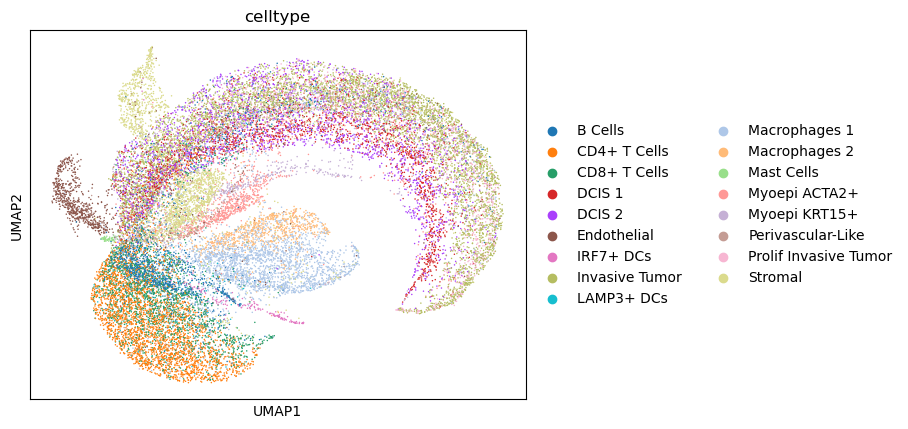

In [3]:
# PCA + UMAP
sc.pp.pca(adata_sc)
sc.pp.neighbors(adata_sc)
sc.tl.umap(adata_sc)

sc.pl.umap(adata_sc, color = "celltype")

In [4]:
counts_sc = pd.DataFrame(adata_sc.X.toarray().astype(int), index = adata_sc.obs.index, columns = adata_sc.var_names)
counts_sc.to_csv(os.path.join(save_path, "rawdata", "sc_counts.csv"))

In [5]:
adata_sc.obs.to_csv(os.path.join(save_path, "rawdata", "sc_celltype.csv"))

In [6]:
# ST adata with scanvi label and spatial coordinates of mask center
# method = "Cell_10X"
method = "UCS_10X"
adata_st = sc.read_h5ad(os.path.join(data_dir, "paper_data/downstream_xenium_breast_cancer/scVI_output", method, "annotated_adata_st.h5ad"))

In [7]:
if not os.path.exists(os.path.join(save_path, method)):
    os.makedirs(os.path.join(save_path, method))
if not os.path.exists(os.path.join(save_path, "rawdata", method)):
    os.makedirs(os.path.join(save_path, "rawdata", method))

In [8]:
adata_st

AnnData object with n_obs × n_vars = 165734 × 307
    obs: 'tech', '_scvi_batch', '_scvi_labels', 'celltype_scanvi', 'C_scANVI'
    uns: 'C_scANVI_colors', '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'tech_colors'
    obsm: 'X_mde_scanvi', 'X_scANVI', 'X_scVI', 'X_scVI_mde', 'spatial'
    layers: 'counts'

In [9]:
n_spots = adata_st.n_obs
n_samples = 10000
random_indices = np.random.choice(n_spots, size=n_samples, replace=False)
adata_st_subset = adata_st[random_indices]

In [10]:
counts = pd.DataFrame(adata_st_subset.layers["counts"].toarray().astype(int),index=adata_st_subset.obs.index,columns=adata_st_subset.var_names)
counts.to_csv(os.path.join(save_path, "rawdata", method, "counts.csv"))

In [11]:
adata_st_subset.obsm['spatial']

ArrayView([[3248., 1250.],
           [2689., 4146.],
           [3550.,  678.],
           ...,
           [ 130., 5150.],
           [4350., 6159.],
           [5380., 1155.]])

In [12]:
coordinates = pd.DataFrame(adata_st_subset.obsm['spatial'].toarray(),index=adata_st_subset.obs.index, columns=["x","y"])
coordinates.to_csv(os.path.join(save_path, "rawdata", method, "coordinates.csv"))

In [13]:
scvi_label = pd.DataFrame(adata_st_subset.obs["C_scANVI"],index=adata_st_subset.obs.index)
scvi_label.columns = ["celltype"]
scvi_label.to_csv(os.path.join(save_path, "rawdata", method, "scvi_label.csv"))

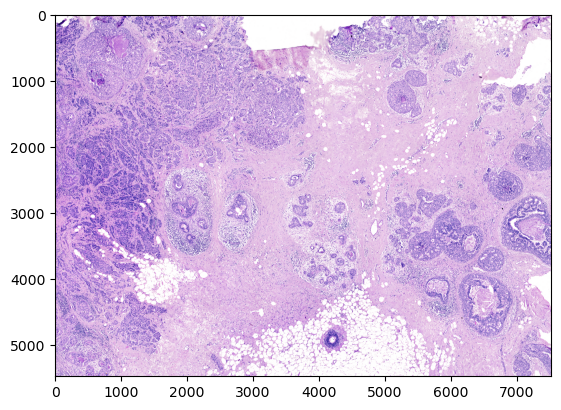

In [14]:
# H&E image
import matplotlib.pyplot as plt
he = tifffile.imread(os.path.join(data_dir, "he.tif"))
plt.imshow(he.transpose(1, 2, 0))

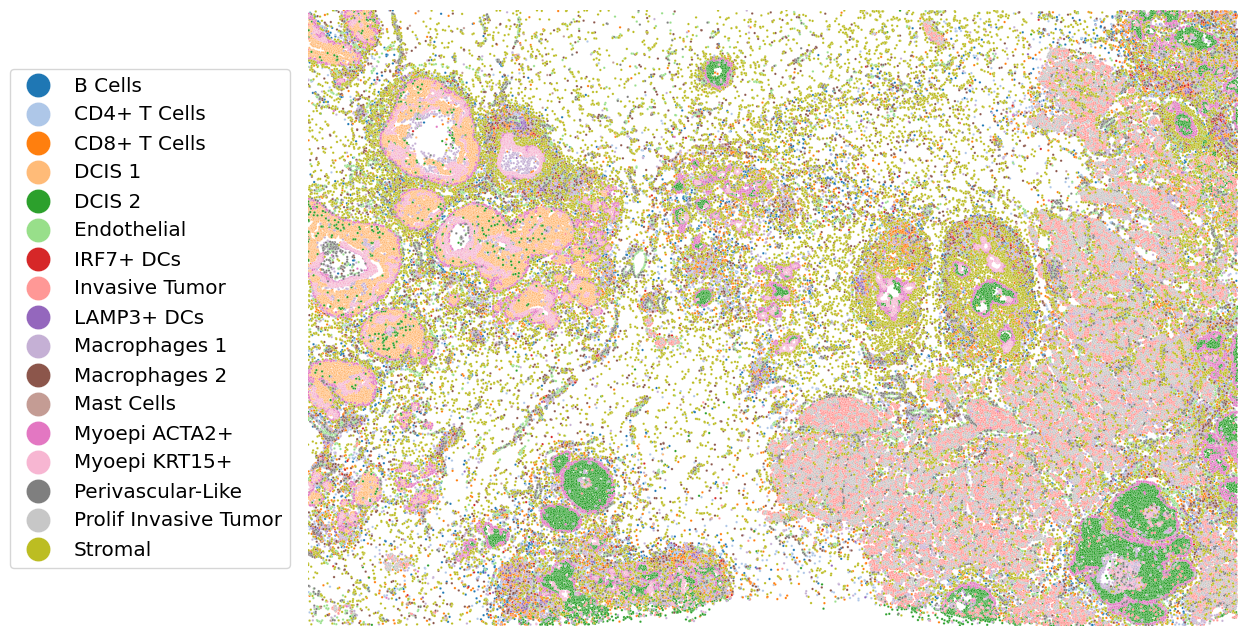

In [15]:
# Visualization of UCS results

import seaborn as sns

mask = tifffile.imread(os.path.join(data_dir, "UCS_10X.tif"))

# reset style
plt.style.use('default')
plt.figure(figsize=(12, 8))
plt.ylim(0, mask.shape[0])
plt.xlim(mask.shape[1], 0)

# Sorted by cell type
plot_df = pd.DataFrame(adata_st.obsm['spatial'], columns=['center_x', 'center_y'])
plot_df['C_scANVI'] = adata_st.obs['C_scANVI'].values
plot_df = plot_df.sort_values(by='C_scANVI')
# Selected Endothelial and invasive Tumor / Prolif Invasive Tumor
# plot_df = plot_df[plot_df['C_scANVI'].isin(["DCIS 1", "DCIS 2", "Invasive Tumor", "Prolif Invasive Tumor", "T Cell & Tumor Hybrid", "Myoepi ACTA2+", "Myoepi KRT15+"])]
# Change color
sns.scatterplot(x=plot_df['center_y'], y=plot_df['center_x'],
                hue=plot_df['C_scANVI'], s=3 , palette='tab20')
# Legend outside
plt.legend(bbox_to_anchor=(-0.32, 0.5), loc='center left', borderaxespad=0., fontsize='x-large', markerscale=10)
# No axis
plt.axis('off')
plt.savefig("/import/home/share/zw/pql/results/breast_cancer/breast_cancer.png", format='png', bbox_inches='tight')
plt.show()